In [175]:
%%javascript
$.getScript('http://homes.esat.kuleuven.be/~mjuarezm/ipy_toc.js')

<IPython.core.display.Javascript object>

<h1 id="tocheading">Table of Contents</h1>
<div id="toc"></div>

In [176]:
# ipy imports
%matplotlib inline
from IPython.display import HTML
from IPython.core.interactiveshell import InteractiveShell

# Notebook config
InteractiveShell.ast_node_interactivity = "all"

In [177]:
# button to toggle code
HTML('''<form action="javascript:code_toggle()">
            <input type="submit" value="Toggle cells">
        </form>
     ''')

# Introduction

The objective of this analysis is to study the distribution of network jitter in Tor nodes. Some nodes might have a significantly large jitter than the average. We believe that in those cases, website fingerprinting may have lower effectiveness than in the nodes with low jitter. The rationale is that even if the Tor path is independent of the website, the interaction between the page structure (HTTP request/response pattern) and the jitter, may make the fingerprint less reliable than in high-jitter paths.

In [178]:
import re
from os import listdir
from os.path import join, dirname, realpath, isdir, getmtime, splitext
from glob import glob

import numpy as np
import pandas as pd

import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.style.use('ggplot')

from ggplot import *

# directories
BASE_DIR = dirname(realpath("__file__"))
RESULTS_DIR = join(BASE_DIR, 'results')
LATEST_FILE = max([join(RESULTS_DIR, d)
                   for d in listdir(RESULTS_DIR)], key=getmtime)
LATEST_DATA = '%s.csv' % splitext(LATEST_FILE)[0]

In [179]:
# URLs
ATLAS = '<a href="https://atlas.torproject.org/#details/{fp}" target="_blank">{fp}</a>'

def fp2url(df):
    """Convert node fingerprints to links to Tor Atlas."""
    fp_re = re.compile(r"([A-F0-9]{40})", re.MULTILINE | re.UNICODE)
    def repl_fp(match):
        match = match.group()
        return ATLAS.format(fp=match)
    return fp_re.sub(repl_fp, df.to_html())

# Data collection


 To collect a latency sample, we make a TCP connection to the node's OR port and record the SYN and SYN+ACK packets. We have collected the latency dataset in batches, that is iterating over the whole list of nodes multiple times and taking several samples of each node in each iteration. This allows to obtain a more reliable estimate of the latency at a fixed time and obtain estimates of the latency at different times. In total, we have collected:

In [180]:
# load data
data = pd.read_csv(join(LATEST_DATA))

num_samples = len(data)
print "- Total num samples:", num_samples

nodes = data.groupby(['fp'])['fp'].count()
num_nodes = len(nodes)
print "- Found data for", num_nodes, "nodes"

avg_num_samples_per_nodes = nodes.mean()
print "- An average of", int(avg_num_samples_per_nodes), "samples for each node."
print "\n"

data.head()

- Total num samples: 26285
- Found data for 5276 nodes
- An average of 4 samples for each node.




,batch_id,sample_id,fp,flags,latency
0,1.717043e+07,0,000A10D43011EA4928A35F610405F92B4433B4DC,Running Stable Valid,0.205980
1,1.717043e+07,1,000A10D43011EA4928A35F610405F92B4433B4DC,Running Stable Valid,0.165011
2,1.717043e+07,2,000A10D43011EA4928A35F610405F92B4433B4DC,Running Stable Valid,0.190140
3,1.717043e+07,3,000A10D43011EA4928A35F610405F92B4433B4DC,Running Stable Valid,0.183718
4,1.717043e+07,4,000A10D43011EA4928A35F610405F92B4433B4DC,Running Stable Valid,0.183022


In [181]:
# get stats for each sample batch
batches = pd.DataFrame(group[['latency']].describe().rename(columns={'latency': name}).squeeze()
                       for name, group in data.groupby('batch_id')).reset_index()

# get unique latency stats
header = ['fp', 'flags'] + [name for name in data.describe().index]
lats = data.merge(batches, left_on='batch_id', right_on='index')[header].drop_duplicates()

# Latency

From the traffic traces collected for the TCP connections to the nodes, we extract the first SYN+ACK packet (if any) and its corresponding SYN packet. Next, we substract the SYN timestamp to the SYN+ACK timestamp to obtain a measurement of the latency to a node.

Some basic statistics about the per-node median latencies:

In [182]:
lats['50%'].describe()

count    5276.000000
mean        0.103600
std         0.178023
min         0.017356
25%         0.049432
50%         0.068676
75%         0.120062
max         6.417185
Name: 50%, dtype: float64

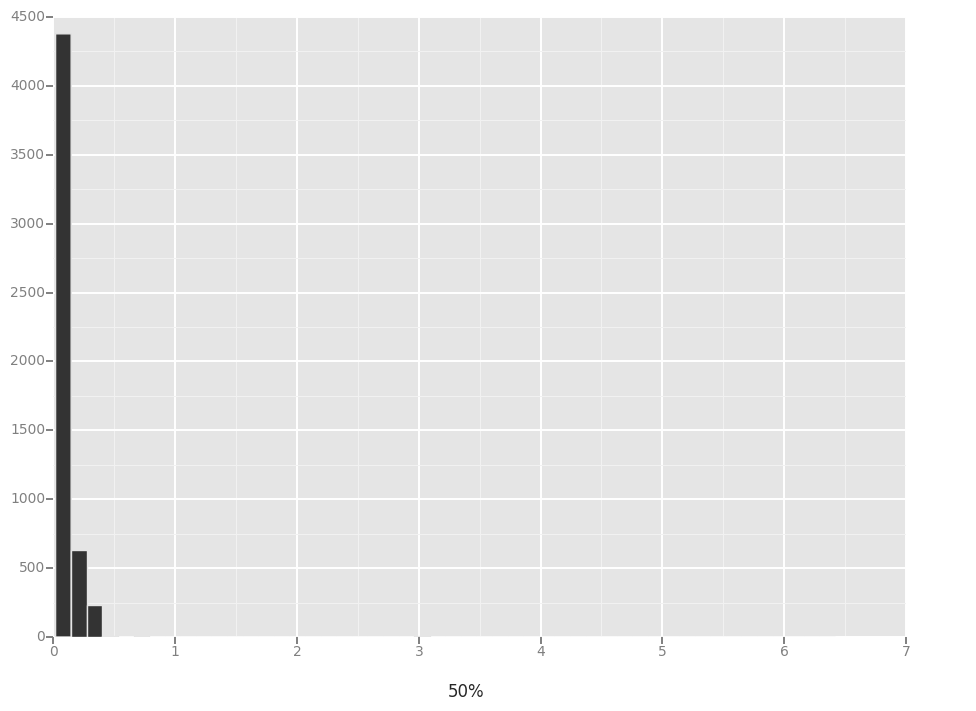

<ggplot: (8788792040029)>

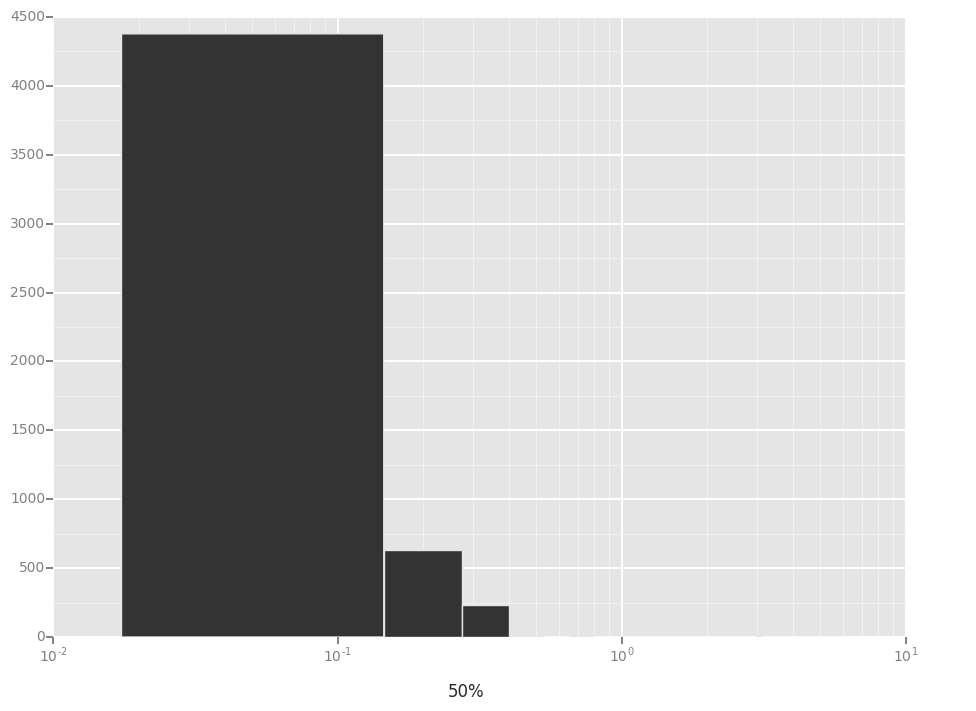

<ggplot: (8788794915197)>

In [183]:
# histogram of latencies
ggplot(lats, aes(x='50%')) + geom_histogram(bins=50)

ggplot(lats, aes(x='50%')) + geom_histogram(bins=50) + scale_x_log()

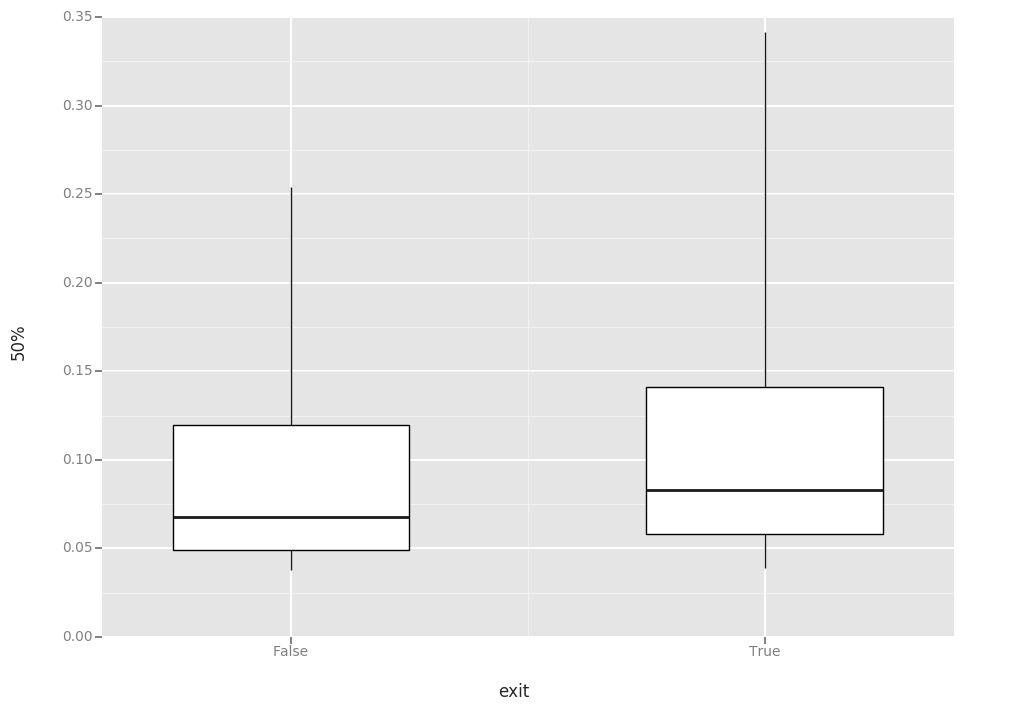

<ggplot: (8788795268737)>

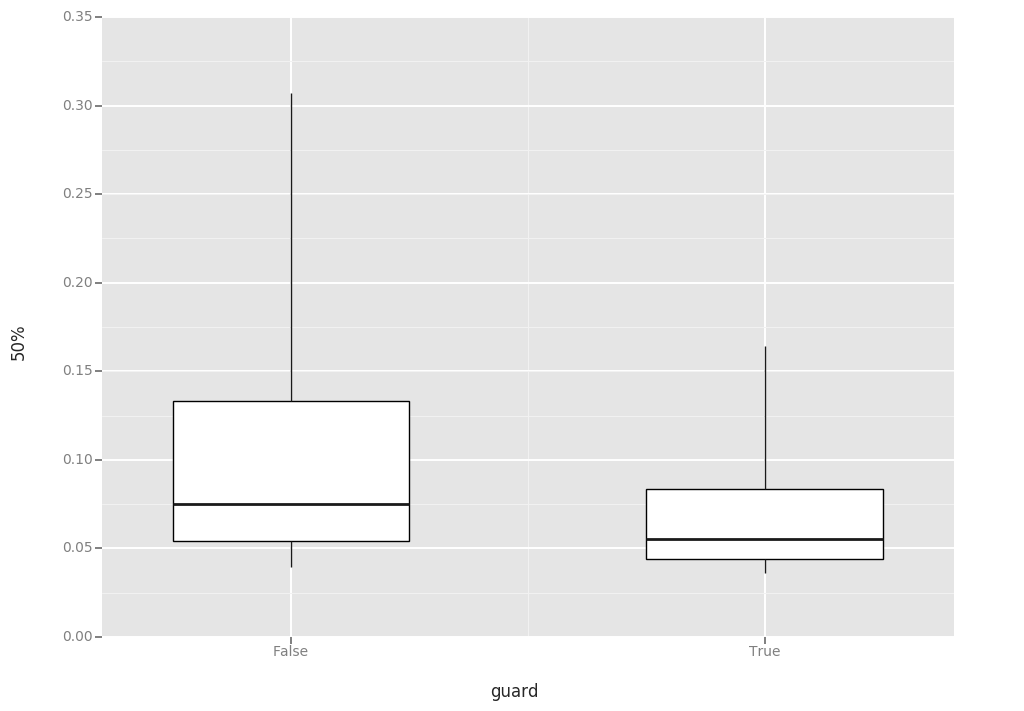

<ggplot: (8788795357913)>

In [184]:
# check if node is exit or guard
lats['guard'] = lats.flags.str.contains('Guard')
lats['exit'] = lats.flags.str.contains('Exit')

# boxplot exit or non-exit
ggplot(lats, aes(x='exit', y='50%')) + geom_boxplot(outliers=False)

# boxplot guard or non-guard
ggplot(lats, aes(x='guard', y='50%')) + geom_boxplot(outliers=False)

Top nodes by median latency:

In [185]:
top_lat = lats.sort_values(['50%'], ascending=False).head()
HTML(fp2url(top_lat[['fp', '50%']]))

,fp,50%
10703,52D60084AFFF74A4CFD07B8ABBEAE114DEB0BAF9,6.417185
7506,39EB2F7C4C87F446134966D84CB2030DD0127478,3.367739
7456,3963F78F86EB64A11F94CEE76ADD4C7CF7979DD7,3.181068
23655,B9353EEABE33FBE3E2FED5090C5F373F402091D8,3.119905
18856,94DC6D7FDA7CB371120492194A73E4B02A247F0E,3.087978


# Jitter

We measure jitter of a node as the variance of the node's latency across batches and within a batch.

In [186]:
# we already have jitter within batch
jitter_batch = lats.groupby('')['50%'].std().reset_index(name='jitter')

# compute jitter across batches
jitter_batches = lats.groupby('fp')['50%'].std().reset_index(name='jitter')

Top nodes by jitter:

In [187]:
#top_jitter = node_stats.sort_values(['jitter'], ascending=False).head()
#HTML(fp2url(top_jitter))